# Hydration Shell and Backbone Atoms

Parameters:

* $c$ -- cutoff
* $b$ -- number of bins for each pair of atom types

In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn
from multiprocessing import Pool, TimeoutError
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize, MaxAbsScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  BayesianRidge, ElasticNet, Ridge)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from data_mining import *

In [2]:
mat_file_patterns = []

for cutoff in [9, 12, 15, 18, 21, 24]:
    for num_dist_bins in [1, 2, 3, 4, 5, 10, 15]:
        for num_angle_bins in [1, 2, 3, 4, 5, 10, 15, 20]:
            mat_file_patterns.append(
                '*solvation-b{}-a{}-c{}--skip_errors.mat'.format(num_dist_bins, num_angle_bins, cutoff)
            )

In [3]:
checksums = ['8269eab4b9ebaa69aa1467308c48ed4f']

In [4]:
def get_natives(scores):
    natives = np.array([bool(re.match('T0...\.pdb', x.split('/')[-1])) for x in scores.index])
    return pd.Series(data=natives, index=scores.index)

In [5]:
models = [
    ("Normalizer + Ridge",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(normalize=False, fit_intercept=False, solver='sparse_cg'))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X)),
    ("MaxAbsScaler + Ridge",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(normalize=False, fit_intercept=False, solver='sparse_cg'))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X))
]

In [6]:
scores = load_pickled_dataset(dataset_binary_filename(mat_file_patterns[-200], checksums[0], 'binaries'))[1]
scores = select_subset(scores, scores, '^.*CASP([5-9]|10)/T..../.*$')[1]
indices = scores.index.sort_values().copy()

In [7]:
results_train = {}
results_val = {}

In [8]:
def compute_results(args):
    try:
        mat_file_pattern, indices = args

        for checksum in checksums:
            try:
                X, scores, _ = load_pickled_dataset(
                    dataset_binary_filename(mat_file_pattern, checksum, 'binaries')
                )
                break
            except:
                X, scores = None, None

        if X is None:
            print(mat_file_pattern, '\tError: Dataset not found', flush=True)
            return mat_file_pattern, None

        scores['__temp_index'] = range(scores.shape[0])
        scores = scores.loc[indices]
        if pd.isnull(scores['__temp_index']).sum():
            print(mat_file_pattern, '\tError: Got smaller dataset', flush=True)
            return mat_file_pattern, None

        X = X[scores['__temp_index'].values]
        del scores['__temp_index']

        old_shape = X.shape
        X, nonzero_features = remove_zero_features(X)
        print(mat_file_pattern, '\tX.size: {},\t{} -> {}'.format(X.size, old_shape, X.shape), flush=True)

        train_blocks, train_idx, val_blocks, val_idx = train_test_split(one_hot_from_scores(scores),
                                                                        test_ratio=0.4, seed=17)
        X_train = X[train_idx]
        X_val = X[val_idx]
        del X
        scores_train = scores[train_idx]
        scores_val = scores[val_idx]

        results_train = {}
        results_val = {}

        for model_name, model, train, predicted_score in models:

            ### Train
            train(model, X_train, scores[train_idx])

            ### Results on training set
            results_train[model_name + ' + native'], _ = scoring_results(X_train, scores_train,
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)

            results_train[model_name], _ = scoring_results(X_train[~get_natives(scores_train).values],
                                                           scores_train[~get_natives(scores_train).values],
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)
            ### Results on validation set
            results_val[model_name + ' + native'], _ = scoring_results(X_val, scores_val,
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

            results_val[model_name], _ = scoring_results(X_val[~get_natives(scores_val).values],
                                                         scores_val[~get_natives(scores_val).values],
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

        return mat_file_pattern, (results_train, results_val)
    except Exception as e:
        print(mat_file_pattern, '\tError: Exception', e, flush=True)
        return mat_file_pattern, None

In [25]:
pool = Pool(processes=4)
pool_result = pool.imap_unordered(compute_results, [(mat_file_pattern, indices)
                                       for mat_file_pattern in mat_file_patterns
                                       if mat_file_pattern not in results_train.keys()])
pool.close()

In [29]:
returned = []

try:
    while True:
        returned.append(pool_result.next(timeout=0))
except TimeoutError:
    print('Timeout')
except StopIteration:
    print('Done')

for mat_file_pattern, res in returned:
    if res:
        results_train[mat_file_pattern], results_val[mat_file_pattern] = res

len(returned), len([x for x in returned if x[1]])

Timeout


(71, 0)

## Test

In [30]:
params = ['c', 'b', 'a']

In [31]:
def mean_top1_score(scores):
    return scores['GDT-TS-score']['Mean score for top 1']

def correlation_score(scores):
    return -scores['GDT-TS-score'][['Mean Pearson', 'Mean Spearman']].mean()

def summary(results):
    records = []
    for quality_criterion in [mean_top1_score, correlation_score]:
        for model in sorted(list(results.items())[0][1].keys()):
            benchmark = generate_benchmark(results, quality_criterion)
            best_dataset = benchmark[model].argmax()
            records.append((best_dataset,
                            model + ' + ' + quality_criterion.__name__,
                            results[best_dataset][model]['GDT-TS-score']))
    df = pd.concat([x[2] for x in records], axis=1)
    df.columns = [x[1] for x in records]
    df.loc['The best dataset'] = [x[0] for x in records]
    return df

def plot_results(results, model, quality_criterion, params, **kwargs):
    benchmark = generate_benchmark(results, quality_criterion)
    plot_heatmaps(benchmark, model, params, **kwargs)

    print('The best:\n{}'.format(benchmark[model].argmax()))
    display(results[benchmark[model].argmax()][model])

In [32]:
df = summary(results_val)
display(df.iloc[:, [c.split(' + ')[-2] == 'native' for c in df.columns]].T)
display(df.iloc[:, [c.split(' + ')[-2] != 'native' for c in df.columns]].T)

Mean rank of the native  \
MaxAbsScaler + Ridge + native + mean_top1_score                   70.2876   
Normalizer + Ridge + native + mean_top1_score                     61.8319   
MaxAbsScaler + Ridge + native + correlation_score                 63.1903   
Normalizer + Ridge + native + correlation_score                   65.2035   

                                                       Top 1     Top 5  \
MaxAbsScaler + Ridge + native + mean_top1_score     0.132743  0.207965   
Normalizer + Ridge + native + mean_top1_score       0.106195  0.243363   
MaxAbsScaler + Ridge + native + correlation_score   0.141593  0.265487   
Normalizer + Ridge + native + correlation_score    0.0884956  0.243363   

                                                  Mean score for top 1  \
MaxAbsScaler + Ridge + native + mean_top1_score               0.576759   
Normalizer + Ridge + native + mean_top1_score                   0.4957   
MaxAbsScaler + Ridge + native + correlation_score             0.558466   
Normalizer + Ridge + native + correlation_score                 0.4784   

                                                  Mean loss score  \
MaxAbsScaler + Ridge + native + mean_top1_score          0.423241   
Normalizer + Ridge + native + mean_top1_score              0.5043   
MaxAbsScaler + Ridge + native + correlation_score        0.441534   
Normalizer + Ridge + native + correlation_score            0.5216   

                                                  Mean Pearson Mean Spearman  \
MaxAbsScaler + Ridge + native + mean_top1_score      -0.493295     -0.412367   
Normalizer + Ridge + native + mean_top1_score        -0.480376      -0.39351   
MaxAbsScaler + Ridge + native + correlation_score    -0.498828     -0.422274   
Normalizer + Ridge + native + correlation_score      -0.487448     -0.400976   

                                                  Mean Kendall tau      PMCC  \
MaxAbsScaler + Ridge + native + mean_top1_score          -0.293066 -0.398634   
Normalizer + Ridge + native + mean_top1_score            -0.280396 -0.432696   
MaxAbsScaler + Ridge + native + correlation_score        -0.300677 -0.406847   
Normalizer + Ridge + native + correlation_score          -0.287171 -0.448549   

                                                       SMCC    wmPMCC  \
MaxAbsScaler + Ridge + native + mean_top1_score   -0.434201 -0.548524   
Normalizer + Ridge + native + mean_top1_score     -0.467133 -0.540532   
MaxAbsScaler + Ridge + native + correlation_score -0.447502 -0.555236   
Normalizer + Ridge + native + correlation_score   -0.477342 -0.549393   

                                                     wmSMCC Mean Z-score  \
MaxAbsScaler + Ridge + native + mean_top1_score   -0.439343      1.16446   
Normalizer + Ridge + native + mean_top1_score      -0.42031     0.573176   
MaxAbsScaler + Ridge + native + correlation_score  -0.44996      1.03204   
Normalizer + Ridge + native + correlation_score   -0.430012     0.369425   

                                                                          The best dataset  
MaxAbsScaler + Ridge + native + mean_top1_score      *solvation-b4-a3-c15--skip_errors.mat  
Normalizer + Ridge + native + mean_top1_score      *solvation-b15-a10-c15--skip_errors.mat  
MaxAbsScaler + Ridge + native + correlation_score    *solvation-b3-a2-c15--skip_errors.mat  
Normalizer + Ridge + native + correlation_score    *solvation-b10-a10-c18--skip_errors.mat

Mean rank of the native       Top 1  \
MaxAbsScaler + Ridge + mean_top1_score                   76.5442   0.0221239   
Normalizer + Ridge + mean_top1_score                      82.354   0.0132743   
MaxAbsScaler + Ridge + correlation_score                 78.0973           0   
Normalizer + Ridge + correlation_score                    80.354  0.00442478   

                                              Top 5 Mean score for top 1  \
MaxAbsScaler + Ridge + mean_top1_score    0.0663717              0.49743   
Normalizer + Ridge + mean_top1_score      0.0575221             0.426498   
MaxAbsScaler + Ridge + correlation_score  0.0663717             0.476771   
Normalizer + Ridge + correlation_score    0.0442478             0.424419   

                                         Mean loss score Mean Pearson  \
MaxAbsScaler + Ridge + mean_top1_score          0.142747    -0.497476   
Normalizer + Ridge + mean_top1_score            0.213679    -0.459946   
MaxAbsScaler + Ridge + correlation_score        0.163406    -0.508795   
Normalizer + Ridge + correlation_score          0.215758    -0.493659   

                                         Mean Spearman Mean Kendall tau  \
MaxAbsScaler + Ridge + mean_top1_score       -0.407709        -0.289232   
Normalizer + Ridge + mean_top1_score         -0.370597        -0.263735   
MaxAbsScaler + Ridge + correlation_score     -0.420147        -0.298899   
Normalizer + Ridge + correlation_score       -0.398768        -0.285334   

                                              PMCC      SMCC    wmPMCC  \
MaxAbsScaler + Ridge + mean_top1_score   -0.389951 -0.426885  -0.55067   
Normalizer + Ridge + mean_top1_score     -0.425152 -0.457843 -0.516803   
MaxAbsScaler + Ridge + correlation_score -0.406013 -0.446709 -0.564447   
Normalizer + Ridge + correlation_score   -0.447916  -0.47656 -0.555714   

                                            wmSMCC Mean Z-score  \
MaxAbsScaler + Ridge + mean_top1_score   -0.433932     0.421303   
Normalizer + Ridge + mean_top1_score     -0.396406    -0.162718   
MaxAbsScaler + Ridge + correlation_score -0.447729      0.29249   
Normalizer + Ridge + correlation_score   -0.427904    -0.111325   

                                                                 The best dataset  
MaxAbsScaler + Ridge + mean_top1_score      *solvation-b2-a4-c15--skip_errors.mat  
Normalizer + Ridge + mean_top1_score      *solvation-b10-a20-c12--skip_errors.mat  
MaxAbsScaler + Ridge + correlation_score    *solvation-b3-a2-c15--skip_errors.mat  
Normalizer + Ridge + correlation_score    *solvation-b10-a10-c18--skip_errors.mat

In [33]:
df2 = generate_benchmark(results_val, lambda scores: scores.ix['Top 1', 'RMSD'])
[p for p in set(df2.columns) - set(list(results_val.items())[0][1].keys()) if len(df2[p].unique()) > 1]

['a', 'c', 'b']

### Regression

#### Row normalization

##### Mean score for top 1

plot_results(results_val,
             'Normalizer + Ridge', mean_top1_score,
             params, info='Validation', num_cols=4, figsize=1.2)

##### Correlation score

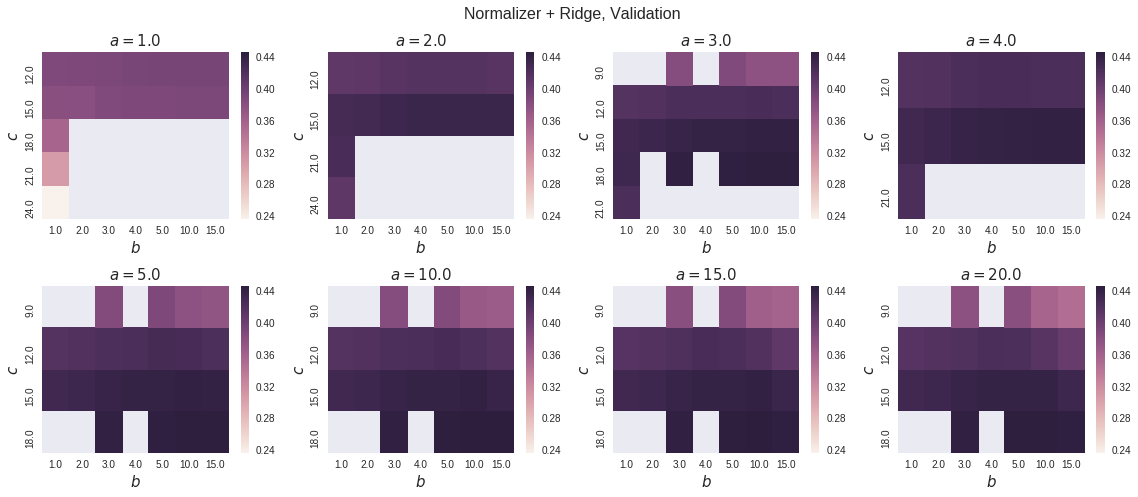

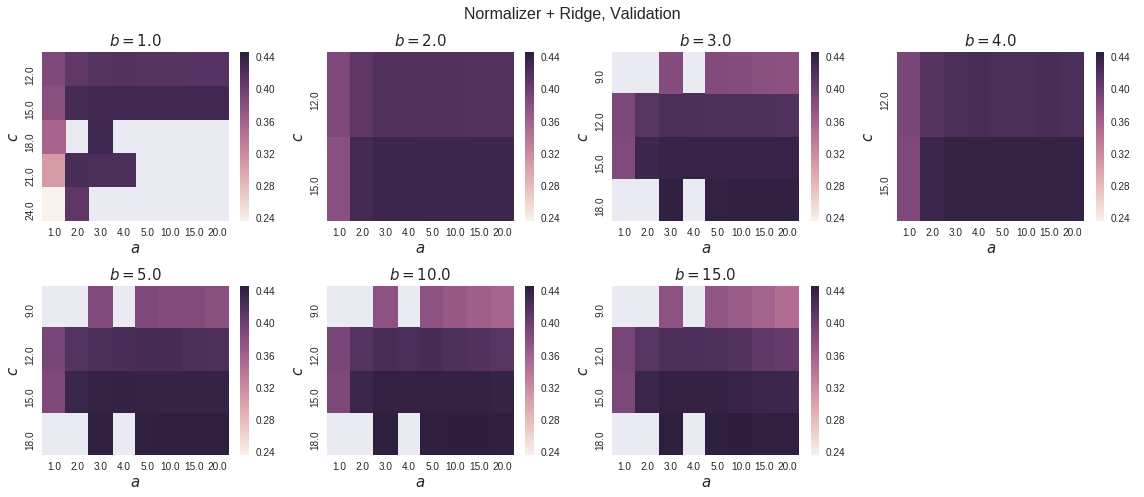

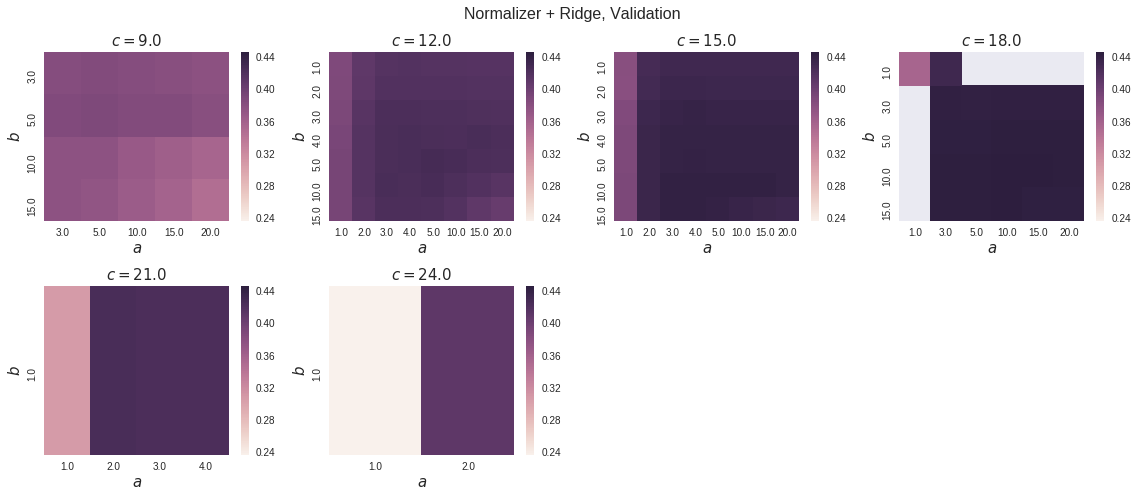

The best:
*solvation-b10-a10-c18--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    121.168      79.208      78.0929       80.354   
Top 1                    0.0176991  0.00884956   0.00442478   0.00442478   
Top 5                    0.0486726   0.0486726     0.039823    0.0442478   
Mean score for top 1       9.30894    0.487014     0.385887     0.424419   
Mean loss score           -6.68234    0.225591     0.223402     0.215758   
Mean Pearson               0.48987   -0.487045    -0.485825    -0.493659   
Mean Spearman             0.401043   -0.398683    -0.396009    -0.398768   
Mean Kendall tau          0.284354   -0.286611    -0.283396    -0.285334   
PMCC                      0.314189   -0.433092      -0.4443    -0.447916   
SMCC                      0.452688   -0.468265    -0.477468     -0.47656   
wmPMCC                    0.533497   -0.549854    -0.548155    -0.555714   
wmSMCC                    0.428144   -0.429303    -0.425904    -0.427904   
Mean Z-score             -0.166207    -0.14358   -0.0863939    -0.111325   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native       77.146        258.097            110.695   
Top 1                     0.00442478              0         0.00442478   
Top 5                      0.0486726              0          0.0309735   
Mean score for top 1        0.294891        9.30894           0.496859   
Mean loss score             0.181531        54.5262            0.25745   
Mean Pearson               -0.480213        0.48987          -0.496099   
Mean Spearman              -0.386274       0.401028           -0.40924   
Mean Kendall tau           -0.274747       0.284396          -0.292916   
PMCC                       -0.438285       0.314189          -0.432077   
SMCC                       -0.473743       0.452687          -0.462922   
wmPMCC                     -0.538469       0.533497          -0.558056   
wmSMCC                     -0.414503       0.428127           -0.44144   
Mean Z-score                -0.12998      -0.166207         -0.0122336   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                129.947                132.261   
Top 1                                0.0176991              0.0176991   
Top 5                                0.0486726               0.039823   
Mean score for top 1                  0.402165               0.446043   
Mean loss score                       0.330641               0.312807   
Mean Pearson                         -0.459919              -0.468563   
Mean Spearman                        -0.383383              -0.386118   
Mean Kendall tau                     -0.273684              -0.275421   
PMCC                                 -0.442414              -0.443696   
SMCC                                 -0.470659              -0.467301   
wmPMCC                               -0.526259              -0.534821   
wmSMCC                               -0.414372              -0.416188   
Mean Z-score                         0.0841329              0.0897005   

                        GDT-HA-score-backwards  
Mean rank of the native                131.987  
Top 1                                0.0176991  
Top 5                                 0.039823  
Mean score for top 1                  0.311084  
Mean loss score                        0.29227  
Mean Pearson                         -0.445014  
Mean Spearman                        -0.370192  
Mean Kendall tau                     -0.262557  
PMCC                                 -0.435628  
SMCC                                 -0.464344  
wmPMCC                               -0.507278  
wmSMCC                               -0.398922  
Mean Z-score                          0.076335

In [34]:
plot_results(results_val,
             'Normalizer + Ridge', correlation_score,
             params, info='Validation', num_cols=4, figsize=1)

#### Feature normalization

##### Mean score for top 1

plot_results(results_val,
             'MaxAbsScaler + Ridge', mean_top1_score,
             params, info='Validation', num_cols=4, figsize=1.2)

##### Correlation score

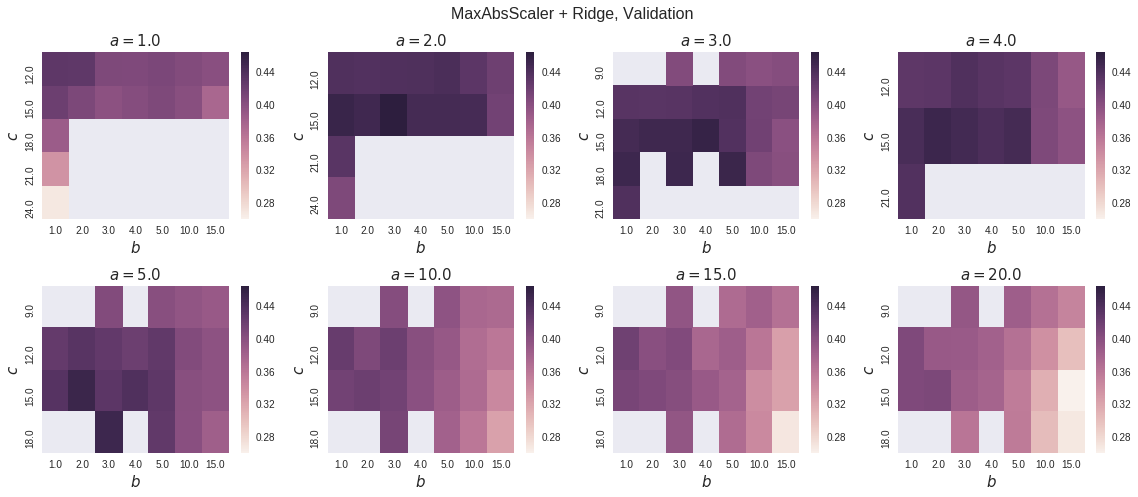

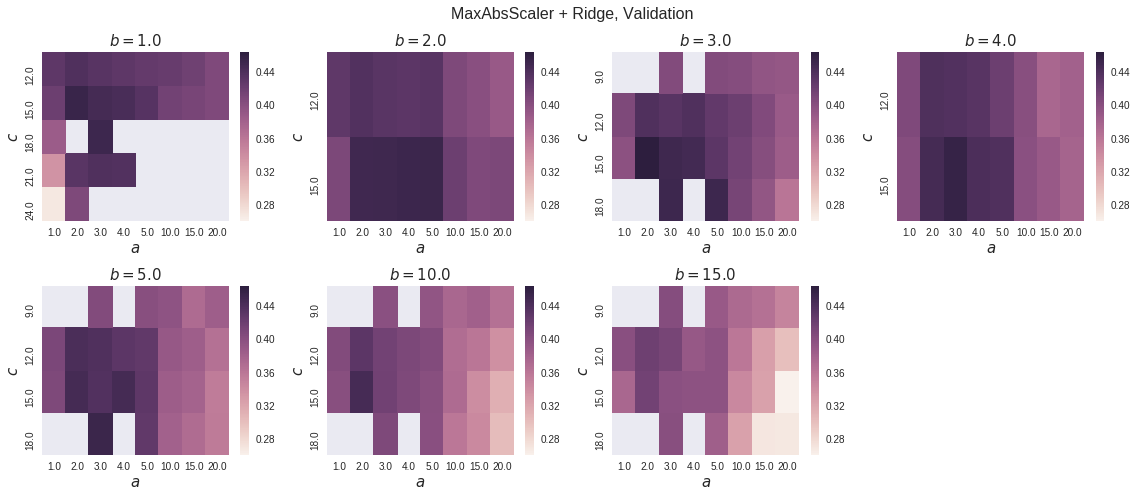

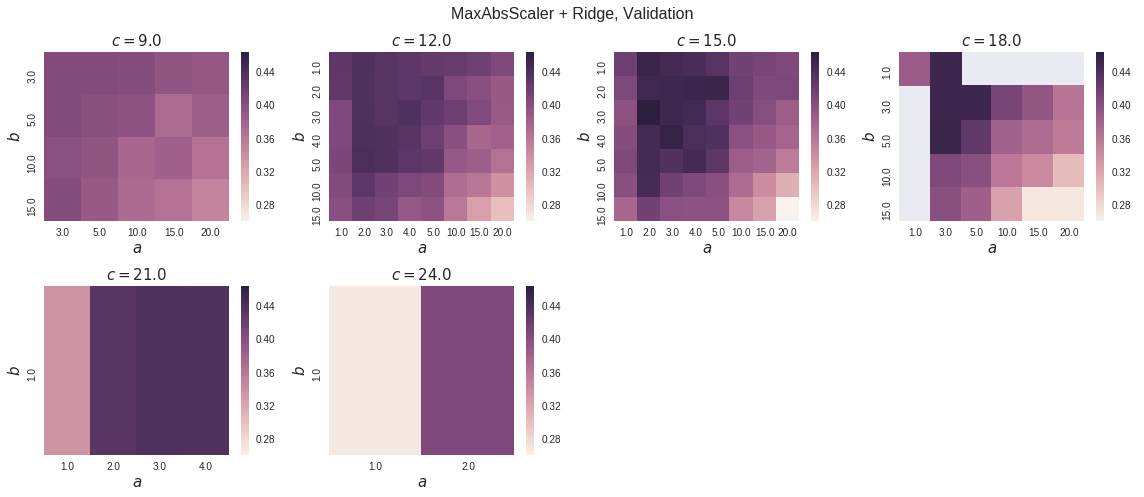

The best:
*solvation-b3-a2-c15--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native     134.093     75.5088      72.7566      78.0973   
Top 1                    0.00442478  0.00884956            0            0   
Top 5                     0.0309735   0.0752212    0.0884956    0.0663717   
Mean score for top 1        10.0687    0.551522     0.435701     0.476771   
Mean loss score             -7.4421    0.161083     0.173588     0.163406   
Mean Pearson               0.445986   -0.502545    -0.497932    -0.508795   
Mean Spearman              0.348413   -0.423242    -0.413397    -0.420147   
Mean Kendall tau           0.243302   -0.302112    -0.294272    -0.298899   
PMCC                       0.269712   -0.434856    -0.405335    -0.406013   
SMCC                       0.378239    -0.49002    -0.451839    -0.446709   
wmPMCC                     0.487553   -0.558279    -0.554422    -0.564447   
wmSMCC                      0.37157   -0.453131    -0.441855    -0.447729   
Mean Z-score              -0.113258    0.314214      0.28588      0.29249   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      74.5575        247.049             126.65   
Top 1                     0.00884956              0                  0   
Top 5                      0.0575221              0          0.0221239   
Mean score for top 1        0.331898        10.0687           0.529086   
Mean loss score             0.144524        53.7664           0.225223   
Mean Pearson               -0.493468       0.445986          -0.473971   
Mean Spearman              -0.403545       0.348431          -0.376416   
Mean Kendall tau           -0.285734       0.243319           -0.26576   
PMCC                        -0.39362       0.269712          -0.419723   
SMCC                       -0.440547       0.378239          -0.463285   
wmPMCC                     -0.546426       0.487553          -0.529522   
wmSMCC                     -0.429882       0.371551          -0.403004   
Mean Z-score                0.250469      -0.113258           0.133043   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                147.367                 149.15   
Top 1                                        0                      0   
Top 5                                0.0221239              0.0132743   
Mean score for top 1                  0.413057                0.45114   
Mean loss score                        0.31975                0.30771   
Mean Pearson                         -0.429946              -0.436801   
Mean Spearman                         -0.35075              -0.349395   
Mean Kendall tau                      -0.24743              -0.246079   
PMCC                                 -0.387799              -0.384626   
SMCC                                 -0.423362              -0.412351   
wmPMCC                               -0.490958              -0.497386   
wmSMCC                               -0.377023              -0.374665   
Mean Z-score                         0.0609578              0.0347615   

                        GDT-HA-score-backwards  
Mean rank of the native                148.119  
Top 1                                        0  
Top 5                                0.0176991  
Mean score for top 1                  0.314013  
Mean loss score                       0.289341  
Mean Pearson                         -0.413684  
Mean Spearman                        -0.338252  
Mean Kendall tau                     -0.237412  
PMCC                                 -0.374142  
SMCC                                 -0.408903  
wmPMCC                               -0.471353  
wmSMCC                               -0.363004  
Mean Z-score                         0.0049212

In [35]:
plot_results(results_val,
             'MaxAbsScaler + Ridge', correlation_score,
             params, info='Validation', num_cols=4, figsize=1)

## Backup

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

### Save dump

In [37]:
if len(results_train) == 0:
    raise Exception('Empty results')
joblib.dump((results_train, results_val), theNotebook + '.pkl')

['benchmark_solvation.pkl']

### Load from dump

In [10]:
results_train, results_val = joblib.load(theNotebook + '.pkl')